# GPU Programming with CuPy

*Disclaimer: Part of this notebook has been inspired by the [CuPy documentation](https://docs-cupy.chainer.org/en/stable/)*, which is also a great resource for a more detailed description of the CuPy API.

In [1]:
import timeit
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

Piz Daint has a node architecture where each node has a single Intel Xeon E5-2690 v3 (Haswell) CPU and a NVIDIA P100 GPU (see [Piz Daint](https://www.cscs.ch/computers/piz-daint/)). The hybrid partition has a total of 5704 of these nodes connected with a network. Since we are currently working on one of these nodes, we have access to a GPU.

Let's take a look if that's really the case. We can use the `nvidia-smi` command to inspect whether there is a GPU available.

In [2]:
%%bash
nvidia-smi

Tue Jun 13 22:08:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:02:00.0 Off |                    0 |
| N/A   24C    P0    25W / 250W |      0MiB / 16280MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

So we can see that we have a Tesla P100 with ID 0. We can also see that we have 16 GB of memory on the GPU (compared that to the 64 GB we have connected to the CPU). We can further see the operating temperature and the power consumption in Watt. The second box lists the programs currently running on the GPU. If at all, there might be only one entry which is our current notebook process since we have already executed `import cupy` above.

On some systems there is more than one GPU (device) and we have to manage all of them using the ID to identify them. Since we only have one GPU on the Piz Daint node, it is fine to assume that all of our GPU programming will be executed on this device and we don't actively have to manage multiple devices.

## Hybrid Node Architecture

Each node of Piz Daint has one Haswell CPU and one P100 GPU. It is interesting to consider the diffrenet node-internal connections and and floating point units and put them into perspective. The following illustration shows the peak floating-point performance of both CPU and GPU, the bandwidth of the connections between them and their respective memories, and the size of the memories. Sizes of the different graphical elements are illustrated with correct relative scale to each other. What becomes immediately apparent is that while the GPU has a much higher peak floating-point performance and a much higher memory bandwidth, the connection between the CPU and the GPU may become a critical bottleneck.

![hybrid node architecture](img/cpu_gpu_bw_flops.png)

It is important to keep in mind, that only the CPU is actually connected to disk (or the internet) and that all data we want to work on initially has to be read from the CPU (into its memory). If we want to leverage the power of the GPU, we have to move data over to the GPU, do the work, and then transfer the results back to the CPU.

## Memory Managment and Data Transfer

A fundamental difficulty of GPU programming, is that the GPU does not share the memory with the CPU. This means that we have to actively manage where data is placed as well as data movement. For example, if we want to print data on the GPU to the screen, the data has to be copied from the GPU memory to the CPU memory and only then we can display it on the screen. Inversely, if we have loaded a data set from disk, it will reside in the memory of the CPU. We have to explicitly copy the data to the GPU memory before we can work on it on the GPU.

While GPUs are much faster than CPUs (higher peak FLOP/s and higher memory bandwidth), one of the main difficulties of GPU programming is making sure that the benefit of this faster processing speed is offset by the overhead of moving the data from the CPU to the GPU and the results back.

Luckily, CuPy - in contrast to other GPU programming models such as CUDA or OpenACC - handles some of memory managment complexity for us. Let's start out with a simple example.

In [3]:
# import both numpy and cupy
import numpy as np
import cupy as cp

# create a data array in CPU memory
x_cpu = np.array([1, 2, 3])

# create a data array in GPU memory
x_gpu = cp.array([1, 2, 3])

# show values
print(x_cpu)
print(x_gpu)

[1 2 3]
[1 2 3]


Didn't we just say that we cannot print data values which reside in GPU memory? While this is true in principle, CuPy handles the copy from GPU to CPU and the print for us. But we can see that there are limits to this "illusion" when we try to assign the values of one of these arrays to the other.

In [4]:
x_cpu[:] = x_gpu[:]

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

While this would be a perfectly legal operation for two regular numpy arrays, assigning values of an array in GPU memory to an array in CPU memory cannot be done. This is very similar to the distributed memory situation where we had to use the MPI library to send messages from one rank to another in order to transfer data, because the different ranks did not share the same memory space.

We can also see that these two arrays are different, because they have different attributes. An example is the `.device` attribute which contains the GPU device ID on which the array resides, which is not defined for the CPU array.

In [5]:
print(x_gpu.device)
print(x_cpu.device)

<CUDA Device 0>


AttributeError: 'numpy.ndarray' object has no attribute 'device'

In order to move data from the CPU memory (host) to the GPU memory (device) we have to us the `cupy.asarray()` method. In order to move data from the GPU memory (device) back to the CPU memory (host) we can use the `cupy.ndarray.get()` method.

In [6]:
del x_cpu, x_gpu

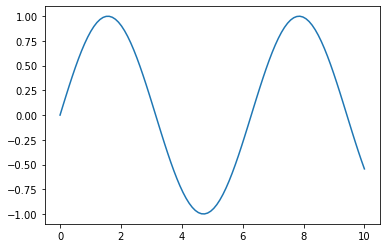

In [7]:
# generate an array on the host (CPU)
x_cpu = np.linspace(0., 10., 100)

# copy the data to the device (GPU)
x_gpu = cp.asarray(x_cpu)

# do some computation on the GPU
y_gpu = cp.sin(x_gpu)

# copy the result back to the host (CPU)
y_cpu = y_gpu.get()

# show the result
plt.plot(x_cpu, y_cpu);

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Define two matrices A and B of size 4096 x 4096 and initialize them with random numbers. Copy them to the GPU. Execute matrix multiplication on the GPU (you can use the <tt>cp.dot()</tt> method) and store the result in C. Copy the result back to the CPU. Validate your result using <tt>np.isclose()</tt> against a CPU reference calculation.<br>
</div>

In [8]:
# TODO matrix multiplication
n = 128
A = np.random.rand(n, n)
B = np.random.rand(n, n)

A_gpu = cp.asarray(A)
B_gpu = cp.asarray(B)

C_gpu = cp.dot(A_gpu, B_gpu)

C = C_gpu.get()

np.isclose(C, np.dot(A,B))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

# Synchronization

CuPY adopts an asynchronous model for GPU execution. This basically means that the CPU simply tells the GPU what work it would like to be done and the CuPy call returns immediately while the GPU is doing the work in the background. (For GPU enthusiasts, this means that a kernel is being launched in a stream.)

Similar to the `!$omp barrier` directive which synchronizes a team of threads and the `MPI.COMM_WORLD.Barrier()` which synchronizes a set of processes, CuPy has the `cp.cuda.Device().synchronize()` method which synchronizes CPU and GPU execution. Basically, the `cp.cuda.Device().synchronize()` waits until both the GPU and the CPU have arrived at this statement in the program execution.

In [9]:
num_elements = 256 * 1024 * 1024
x_gpu = cp.random.rand(num_elements)

tic = timeit.default_timer()
y_gpu = cp.sin(x_gpu)
toc = timeit.default_timer()
elapsed_time_work = toc - tic

tic = timeit.default_timer()
cp.cuda.Device().synchronize()
toc = timeit.default_timer()
elapsed_time_sync = toc - tic

print("Work time = {:.6f} µs   Sync time = {:.6f} µs".format(elapsed_time_work * 1.e6, elapsed_time_sync * 1.e6))

Work time = 2196.198096 µs   Sync time = 14001.582982 µs


<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>2.</b> Change the number of elements to 1 and then gradually increase back to the original value (256 x 1024 x 1024). Does the work time or sync time increase?<br>
<b>3.</b> Add another synchronization just before the first tic to make sure that the CPU and GPU are in sync. Then add another synchronization just before the first toc to make sure that the GPU has finished doing all of its work. Now run again and check how the timers behave when you change the number of elements in the data array.<br>
</div>

It is probably best to define a method for timing that we can use in the future which already includes the syncronization in order to make sure we don't forget it and our timings are off. The above example illustrates how wrong our interpretation of the performance can be if we don't take care to synchronize.

In [10]:
def get_time(sync=True):
    if sync:
        cp.cuda.Device().synchronize()
    return timeit.default_timer()

## Performance and Speedup

One might wonder why one would go to all the trouble of doing all of this work just to compute a `np.sin()` which we could have done much simpler without a GPU. The main reason why we want to use a GPU and are willing to go to the trouble of dealing with host / device memory management is becuase GPUs often allow us to do things much faster.

If you've evern run into the situation where your Python analysis script or your Forran code simply started taking much too long for your laptop to execute, this is where accelerators such as GPUs come in.

In [11]:
num_elements = 64 * 1024 * 1024
x_cpu = np.random.rand(num_elements)

tic = get_time()
y_cpu = np.arctan(x_cpu)
elapsed_time_cpu = get_time() - tic

x_gpu = cp.asarray(x_cpu)

tic = get_time()
y_gpu = cp.arctan(x_gpu)
elapsed_time_gpu = get_time() - tic

speedup = elapsed_time_cpu / elapsed_time_gpu
print("Time CPU = {:.6f} s   Time GPU = {:.6f} ({:.3f}x speedup)".format(elapsed_time_cpu, elapsed_time_gpu, speedup))

Time CPU = 1.705589 s   Time GPU = 0.253416 (6.730x speedup)


<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>4.</b> While the speedup reported above is very impressive, it neglects the time it takes to copy data to the GPU and the result back from the GPU. Insert code to copy the result back. Insert timers around the copy to the GPU and the copy back from the GPU. Make sure you synchronize before a time measurement. Add a print for the speedup relative to the total time including data movement to/from the GPU.<br>
<b>5.</b> The default is an array with 64 x 1024 x 1024 floating point values (each 8 Bytes). Compute how many MB we are transfering to the GPU and back. Compute the bandwidth in GB/s for the transfers to/from the GPU.<br>
<b>6.</b> Try out different number of elements in the array and inspect how speedup changes. What is the minimal array size for a speedup when comparing only the work and when comparing total time including data transfers? What is the maximum speedup you can achieve?<br>
<b>7. (Bonus)</b> Try it out with a simple copy, a simple stencil (e.g. <code>0.5 * (a[i+1] + a[i] + a[i-1])</code> or a matrix-matrix multiplication. How does the maximum speedup change?
</div>

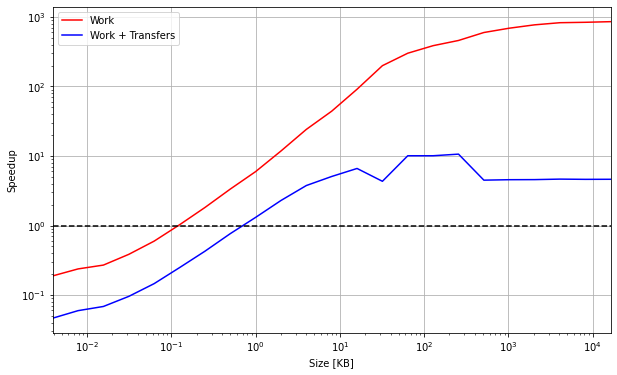

In [13]:
# TODO - speedup including transfers
elapsed_time_cpu = []
elapsed_time_gpu = []
elapsed_time_copy = []
num_bytes = []
for num_elements in 2**np.array(range(3, 28), dtype=np.int32):
    num_bytes += [num_elements // 8]
    x_cpu = np.random.rand(num_elements)

    tic = get_time()
    y_cpu = np.arctan(x_cpu)
    elapsed_time_cpu += [get_time() - tic]

    tic = get_time()
    x_gpu = cp.asarray(x_cpu)
    elapsed_time_copy += [get_time() - tic]

    tic = get_time()
    y_gpu = cp.arctan(x_gpu)
    elapsed_time_gpu += [get_time() - tic]

    tic = get_time()
    y_cpu = y_gpu.get()
    elapsed_time_copy[-1] += get_time() - tic

elapsed_time_cpu = np.array(elapsed_time_cpu)[2:]
elapsed_time_gpu = np.array(elapsed_time_gpu)[2:]
elapsed_time_total = elapsed_time_gpu + np.array(elapsed_time_copy)[2:]
num_bytes = np.array(num_bytes, dtype=float)[2:]

fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(num_bytes / 1024, elapsed_time_cpu / elapsed_time_gpu, 'r', base=2);
ax.loglog(num_bytes / 1024, elapsed_time_cpu / elapsed_time_total, 'b', base=2);
ax.loglog(num_bytes / 1024, 1. + 0. * num_bytes, 'k--');
ax.set_xlabel('Size [KB]');
ax.set_ylabel('Speedup');
ax.grid(which='major', axis='both')
ax.set_xlim([num_bytes[0] / 1024, num_bytes[-1] / 1024])
ax.legend(['Work', 'Work + Transfers']);
plt.show()

## Array Programming and Vectorization (and its limits)

In order to get good performance with CuPy (and numpy) it is key to use array programming in favor of explicit loop as much as possible. Let's compare the runtime of a vector addition (daxpy) using both array programming and an explicit loop.

In [14]:
size = 64 * 1024
for xp, backend in zip([cp, np], ["cupy", "numpy"]):

    x = xp.random.rand(size)
    y = xp.random.rand(size)
    z = xp.empty_like(x)
    a = xp.pi
  
    tic = get_time()
    z[...] = a * x + y
    elapsed_time_array = get_time() - tic
    
    tic = get_time()
    for i in range(size):
        z[i] = a * x[i] + y[i]
    elapsed_time_loop = get_time() - tic
    
    print("{} \t loop={:.5f}s \t array={:.5f}s \t speedup={:.3f}".format(
        backend, elapsed_time_loop, elapsed_time_array, elapsed_time_loop / elapsed_time_array
    ))

cupy 	 loop=4.27227s 	 array=0.47853s 	 speedup=8.928
numpy 	 loop=0.02690s 	 array=0.00035s 	 speedup=76.940


One can see that it is essential to use array programming notation. Both backends have a larger hit in terms of performance when executing explicit loops over our data arrays.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>8.</b> Try writing the following motifs using array programming:
<ul>
<li>Simple stencil<br>
    $\;\;\phi_i = \left( \phi_{i-1} - 2 \, \phi_i + \phi_{i+1} \right) / \Delta x$<br></li>
<li>Upstream scheme<br>
    $\;\;\phi_i = \begin{cases} u_i \left( \phi_i - \phi_{i-1} \right) / \Delta x \;\;\; u_i \ge 0\\ u_i \left( \phi_{i+1} - \phi_i \right) / \Delta x \;\;\; u_i \lt 0 \end{cases}$<br></li>
<li>Maximum in neighborhood with configurable $n=3$ (assume cyclic boundary conditions)<br>
    $\;\;\phi_i = \max\limits_{j=-n,n} \phi_{i + j}$<br></li>
<li>Fixed-point iteration until converged with $\alpha = 0.01$ and $\epsilon = 1e-4$<br>
    $\;\;\mathrm{while} \,\, \left| \phi_{n+1} - \phi_{n} \right| > \epsilon:$<br>
    $\;\;\;\;\;\phi_{n+1} = (1 - \alpha) \, \phi_n + \alpha \, \phi_n^3$<br></li>
</ul>
</div>

In [15]:
size = 16 * 1024 * 1024
for xp, backend in zip([np, cp], ["numpy", "cupy"]):

    phi = xp.random.rand(size)
    u = xp.random.rand(size)
    phi_new = xp.empty_like(phi)
    dx = 1.0
  
    # simple stencil
    tic = get_time()
    phi_new[1:-1] = (phi[0:-2] - 2. * phi[1:-1] + phi[2:]) / dx
    elapsed_stencil = get_time() - tic
    
    # upstream scheme
    tic = get_time()
    phi_new[1:-1] = u[1:-1] * ( \
        + xp.maximum(0., u[1:-1]) * (phi[1:-1] - phi[0:-2]) / dx \
        + xp.minimum(0., u[1:-1]) * (phi[2:]   - phi[1:-1]) / dx )
    elapsed_upstream = get_time() - tic
    
    # neighbourhood in maximum
    n = 3
    tic = get_time()
    phi_new[...] = xp.roll(phi, -n)
    for shift in range(-n + 1, n + 1):
        phi_new = xp.maximum(phi_new, xp.roll(phi, shift))
    elapsed_max = get_time() - tic
    
    a = 0.1
    eps = 1.e-4
    tic = get_time()
    phi = xp.random.rand(size // 32)
    phi_new = (1 - a) * phi + a * phi ** 3
    while len(xp.where(phi_new != phi)[0]) > 0:
        phi[:] = phi_new
        phi_new = (1 - a) * phi_new + a * phi_new ** 3
        phi_new = xp.where(xp.abs(phi_new - phi) > eps, phi_new, phi)
    elapsed_fixedpoint = get_time() - tic
        
    print("{} \t stencil={:.5f}s \t upstream={:.5f}s \t max={:.5f}s \t fixedpoint={:.5f}s".format(
        backend, elapsed_stencil, elapsed_stencil, elapsed_max, elapsed_fixedpoint
    ))
    

numpy 	 stencil=0.23362s 	 upstream=0.23362s 	 max=1.11387s 	 fixedpoint=3.46494s
cupy 	 stencil=0.48049s 	 upstream=0.48049s 	 max=0.48270s 	 fixedpoint=2.40268s


While often it is possible to write the code using array programming (in vector form), it is not always easy. Some algorithms might actually be very hard, cumbersome or impossible to write using array programming. Typical examples are algorithms with data dependencies, algorithms with variable work depending on the position in the array, or algorithms which work on only a subset of the data array.

CuPy as well as numpy provide some methods to extend what is possible with pure array programming syntax via the `numpy.vectorize` or the `cupy.ElementwiseKernel` and `cupy.ReductionKernel`, or even by being able to plug-in raw CUDA code (see below) by using the `cupy.RawKernel` method. Typically these methods do what we call *break the abstraction*, namely the code starts to diverge between a numpy and a CuPy implementtion, is hardware specific and no longer portable, or requires the knowledge of another programming language and is no longer part of the Python language (e.g. `cupy.RawKernel`).

## Writing CPU/GPU Agnostic Code

CuPy can serve as a drop-in replacement of numpy in many aspects. But your code will most probably not always be running on a system where there is a GPU present. Or you would like to be able to easily switch back and forth between using numpy and CuPy in order to test, develop and/or debug your program. A simple method of writing an CPU/GPU agnostic code is the following.

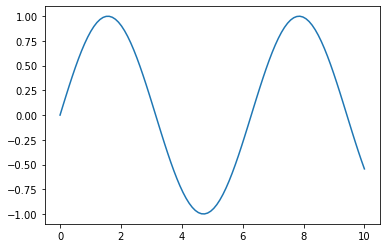

In [16]:
import numpy as np
try:
    import cupy as xp
except ImportError:
    xp = np
    
def get_array(z):
    try:
        return z.get()
    except AttributeError:
        return z

# this is a CPU/GPU agnostic program
x = xp.linspace(0., 10., 100)
y = xp.sin(x)
plt.plot(get_array(x), get_array(y));

It is important to note that the code is slightly different from "normal" numpy code you would write, in that you have to use the `get()` method whenever you would do a transfer from GPU memory to CPU memory (for example for plotting or for writing data to disk). Similarly, when reading data from disk you will initially have a numpy array (irrespective of the backend you are using for `xp`) and using the method `xp.asarray()` will make sure that the data is transferred to the GPU in the case of using CuPy.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>9.</b> Try forcing the above code to run using numpy and CuPy and make sure that it runs with both.
</div>

## Low-level GPU Programming

Executing computations on the GPU with CuPy is extremently convenient and powerful. But it is by far not the only or most common way that GPUs are being used (and as we've seen above also has it's limitations). But why can we not simply use Fortran or C/C++ to program GPUs? The reason is the same as for parallel programing with OpenMP. Most programming languages have not been designed for parallel programming and additional information from the programmer is required because the compilers are (often) not able to automatically parallelize code written in Fortran or C/C++. Furthermore, the programmer also has to explicitly manage data transfers between the CPU and the GPU, in case performance is of any importance.

#### OpenACC Directives

One popular low-level approach to GPU programming are [OpenACC](https://www.openacc.org) compiler directives which can be used in a similar fashion to OpenMP to port an existing Fortran or C/C++ code to GPU (see for example [this tutorial](https://github.com/C2SM-RCM/OpenACC_Training)). Here's an example of OpenACC when used with Fortran.

```Fortran
  ! driving routine for the physical parameterizations
  SUBROUTINE physics()
  IMPLICIT NONE

  INTEGER :: i,j    ! loop indices

  !$acc data present(t,qc,qv) 
  !$acc parallel
  !$acc loop gang
  DO j = 1,ny
  
    !$acc loop vector
    DO i = 1,nx
      DO k = 1, nlev
        v(i,j,k) = qv(i,j,k) + cs1*EXP(cs2*( t(i,j,k)-t0 )/( t(i,j,k)-cs3) )
        qc(i,j,k) = cs4*qv(i,j,k)
      END DO
      DO k = 2, nlev
        qv(i, j, k) = qv(i, j, k-1) + cm1*(t(i, j, k)-cm2)**cm3
        t(i, j, k)  = t(i, j, k)*( 1.0D0 - cm4*qc(i, j, k)+qv(i, j, k) )
      END DO
    END DO

  END DO
  !$acc end parallel
  !$acc end data
  
  END SUBROUTINE physics
```

You can see that there are `!$acc data` statements which are used for data movement / managment. There is a `$!acc parallel` and a `!$acc loop` statement which is the analogue to the `!$omp parallel do` statement. 

#### CUDA

CUDA (Compute Unified Device Architecture) is an extension of the C/C++ programming language and can be used for programming GPUs from NVIDIA. Take a look at [this tutorial](https://www.nvidia.com/content/GTC-2010/pdfs/2131_GTC2010.pdf) if you would like to learn more. An example of a simple CUDA program can be seen below. The `main()` is essentially standard C/C++ except for the decoration of the invocation of the kernel function with `<<<numBlocks, blockSize>>>` and the `__global__` keyword in front of the declaration of the kernel function indicating that this is a function that should run on the GPU. Multiple execution threads will be executing the `add()` funciton in parallel and in the example below an operation such as `y[i] = x[i] + 0.5 * ( y[i+1] + y[i-1] )` would be a race condition and give undefined results.

```C++
#include <iostream>
#include <math.h>

// kernel function to add the elements of two arrays
__global__
void add(int n, float *x, float *y)
{
  int index = blockIdx.x * blockDim.x + threadIdx.x;
  int stride = blockDim.x * gridDim.x;
  for (int i = index; i < n; i += stride)
    y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20;
  float *x, *y;

  // allocate GPU memory
  cudaMalloc(&x, N*sizeof(float));
  cudaMalloc(&y, N*sizeof(float));

  // initialize x and y arrays (to zero)
  cudaMemset(x, 0, N*sizeof(float));
  cudaMemset(y, 0, N*sizeof(float));

  // run kernel
  int blockSize = 256;
  int numBlocks = (N + blockSize - 1) / blockSize;
  add<<<numBlocks, blockSize>>>(N, x, y);

  // free memory
  cudaFree(x);
  cudaFree(y);
  
  return 0;
}
```

#### Accessing Low-Level Programming from CuPy

CuPy allows access to low-level programming with CUDA via the `cupy.RawKernel` method. In order to use this, one has to know the CUDA programming language and have a working knowledge of how GPUs actually work. Below is an example of how one can compile a custom CUDA kernel and launch it from Python.

In [17]:
# define a kernel that adds the column vector y (1d) to all columns of x (2d)
add_and_broadcast_kernel = cp.RawKernel(
    r'''
    extern "C" __global__
    void add_and_broadcast_kernel(
        const float* x, const float* y, float* z,
        const int xdim, const int ydim)
    {
        int idx_x = blockIdx.x * blockDim.x + threadIdx.x;
        int idx_y = blockIdx.y * blockDim.y + threadIdx.y;
        z[idx_y * xdim + idx_x] = x[idx_y * xdim + idx_x] + y[idx_x];
    }
    ''',
    'add_and_broadcast_kernel'
)

# 
def launch_add_and_broadcast_kernel(x, y):
    block_size = (32, 32)
    grid_size = (x.shape[1] // block_size[1], x.shape[0] // block_size[0])

    z = cp.empty(x.shape, x.dtype)
    xdim = x.strides[0] // x.strides[1]
    ydim = z.strides[0] // z.strides[1]

    add_and_broadcast_kernel(grid_size, block_size, (x, y, z, xdim, ydim))
    return z

# allocate storages on GPU
xdim = 4096
ydim = 1024
x = cp.arange(xdim * ydim, dtype=cp.float32).reshape((xdim, ydim))
y = cp.arange(ydim, dtype=cp.float32)

# run the custom kernel
z = launch_add_and_broadcast_kernel(x, y)

# verify the result
print(cp.all(x + y == z))

True


<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>10.</b> Copy the <tt>day1/stencil2d.py</tt> file to a local copy in <tt>day4</tt>. Then create a local copy named <tt>day4/stencil2d-cupy.py</tt>. Port the Python program to GPUs using CuPy and what you have learned in this notebook. Try to make it so, that the program will execute with NumPy in case no CuPy is present. Run the original <tt>day1/stencil2d.py</tt> and your new GPU-enabled version for 16x16, 32x32, 64x64, 96x96 and 128x128 horizontal grid points and make a plot of speedup versus grid size.<br>
<b>11. Bonus</b> Combine your work for the MPI parallel version with the GPU-enabled version. Test your program by validating the output against the serial CPU reference code and by reading the <tt>out_field.npy</tt> data from each version. If you've validated your parallel version, talk to one of the assistants to give it a spin on multiple nodes on Piz Daint. Congrats, you have just written a parallel stencil program that could potentially run on the full Piz Daint!<br>
<b>12. Bonus</b> If you are already familiar with GPU computing, take a stab at porting the <tt>stencil2d.F90</tt> using OpenACC or the <tt>stencil2d.cpp</tt> using CUDA.<br><br>
    
<i>Hint: For running the <tt>stencil2d.py</tt> you can open a Terminal, <code>source HPC4WC_env/bin/activate</code>, <code>export PYTHONPATH=/users/classXXX/HPC4WC_venv/lib/python3.8/site-packages:$PYTHONPATH</code> (where <code>classXXX</code> is your login), and <code>srun -n 1 python stencil2d.py --nx 128 --ny 128 --nz 64 --num_iter 1024 --plot_result True</code></i>.
</div>